### Description synthétique du projet :

Le projet consiste à développer un modèle de prévision des séries temporelles pour la température dans une ville spécifique en utilisant des données météorologiques historiques. Les données sont obtenues à l'aide de l'API Historical Weather (Open-Meteo) et comprennent la température à 2m du sol pour une période de quatre ans, du 01/01/2020 au 31/12/2023.

### Objectifs du projet :

1. Acquisition de données : Récupérer les données de température à partir de l'API Historical Weather pour la ville choisie et pour la période spécifiée.

2. Transformation des données : Créer une nouvelle série temporelle avec un pas de temps de 3h en prenant la moyenne des valeurs pour chaque tranche de 3 heures.

3. Analyse des composantes de la série temporelle : Effectuer une analyse exploratoire des données pour identifier les tendances, les saisons, les motifs saisonniers et les autocorrélations.

4. Expérimentations avec les méthodes statistiques : Implémenter les modèles ARIMA, SARIMA et SARIMAX pour la prévision de la température. Effectuer le tuning des hyperparamètres et évaluer les performances des modèles.

5. Expérimentations avec les méthodes ML de régression : Tester différentes variables explicatives, telles que les variables retardées, les variables construites à partir de valeurs agrégées et les variables exogènes. Utiliser les modèles ML pour prédire la température et comparer les performances avec les modèles statistiques.

6. Analyse des résidus : Évaluer la qualité des modèles en analysant les résidus et en identifiant les éventuels modèles restants.

7. Documentation : Documenter chaque étape du processus, y compris les détails de l'acquisition des données, la transformation des données, l'implémentation des modèles, le tuning des hyperparamètres et l'analyse des résultats.

L'objectif final est de développer un modèle de prévision précis pour la température dans la ville choisie, en utilisant à la fois des méthodes statistiques et des méthodes ML de régression.

### I) Chargement des données

In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline
pd.options.display.float_format = "{:.2f}".format
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (25, 5)
import warnings
# Ignorer tous les avertissements
warnings.filterwarnings("ignore")
# Ignorer un type spécifique d'avertissement, par exemple DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Ignorer tous les avertissements pour le reste du script
warnings.filterwarnings("ignore", category=Warning)


In [8]:
!pip install openmeteo_requests

In [11]:
!pip install requests_cache

In [12]:
!pip install retry_requests

Je travaille avec les données de la ville de douala au cameroun

In [13]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Configuration du client Open-Meteo API avec cache et nouvelle tentative en cas d'erreur
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Coordonnées géographiques de Douala
latitude_douala = 4.0511
longitude_douala = 9.7679

# Dates de début et de fin au format "YYYY-MM-DD"
start_date = "2020-01-01"
end_date = "2023-12-31"

# Assurez-vous que toutes les variables météorologiques requises sont répertoriées ici
# L'ordre des variables dans les données horaires ou quotidiennes est important pour les affecter correctement ci-dessous
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": latitude_douala,
    "longitude": longitude_douala,
    "start_date": start_date,
    "end_date": end_date,
    "hourly": "temperature_2m"
}
responses = openmeteo.weather_api(url, params=params)

# Traiter la première localisation. Ajoutez une boucle for pour plusieurs emplacements ou modèles météorologiques
response = responses[0]
print(f"Coordonnées {response.Latitude()}°N {response.Longitude()}°E")
print(f"Élévation {response.Elevation()} m au-dessus du niveau de la mer")
print(f"Fuseau horaire {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Différence de fuseau horaire par rapport à GMT+1 {response.UtcOffsetSeconds()} s")

# Traiter les données horaires. L'ordre des variables doit être le même que celui demandé.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=hourly.Interval()),
    inclusive="left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m

hourly_dataframe = pd.DataFrame(data=hourly_data)

Coordonnées 4.042179584503174°N 9.755500793457031°E
Élévation 42.0 m au-dessus du niveau de la mer
Fuseau horaire None None
Différence de fuseau horaire par rapport à GMT+1 0 s


In [14]:
hourly_dataframe.head()

,date,temperature_2m
0,2020-01-01 00:00:00+00:00,25.62
1,2020-01-01 01:00:00+00:00,26.42
2,2020-01-01 02:00:00+00:00,24.67
3,2020-01-01 03:00:00+00:00,24.62
4,2020-01-01 04:00:00+00:00,24.77


###  II) Analyse exploratoire des données

In [15]:
hourly_dataframe.shape

(35064, 2)

In [16]:
hourly_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   date            35064 non-null  datetime64[ns, UTC]
 1   temperature_2m  35064 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(1)
memory usage: 411.0 KB


In [17]:
hourly_dataframe.temperature_2m.describe()

count   35064.00
mean       25.71
std         2.40
min        20.72
25%        23.88
50%        25.17
75%        27.12
max        35.47
Name: temperature_2m, dtype: float64

In [18]:
hourly_dataframe.isna().sum()

date              0
temperature_2m    0
dtype: int64

#### 1) Transformation des données : Création d'une nouvelle série temporelle avec un pas de temps de 3h en prenant la moyenne des valeurs pour chaque tranche de 3 heures.

In [19]:
# Convertir la colonne de dates en format datetime et la définir comme index
hourly_dataframe['date'] = pd.to_datetime(hourly_dataframe['date'])
hourly_dataframe.set_index('date', inplace=True)

# Utiliser la fonction resample() pour agréger les données par intervalle de 3 heures et calculer la moyenne
new_hourly_dataframe = hourly_dataframe.resample('3H').mean()

# Afficher la nouvelle série temporelle
new_hourly_dataframe.head()


,temperature_2m
date,
2020-01-01 00:00:00+00:00,25.57
2020-01-01 03:00:00+00:00,24.62
2020-01-01 06:00:00+00:00,26.24
2020-01-01 09:00:00+00:00,30.66
2020-01-01 12:00:00+00:00,30.79


#### 2) Analyse des composantes de la série temporelle : identification des tendances, de la saisonalité, les motifs saisonniers et les autocorrélations.

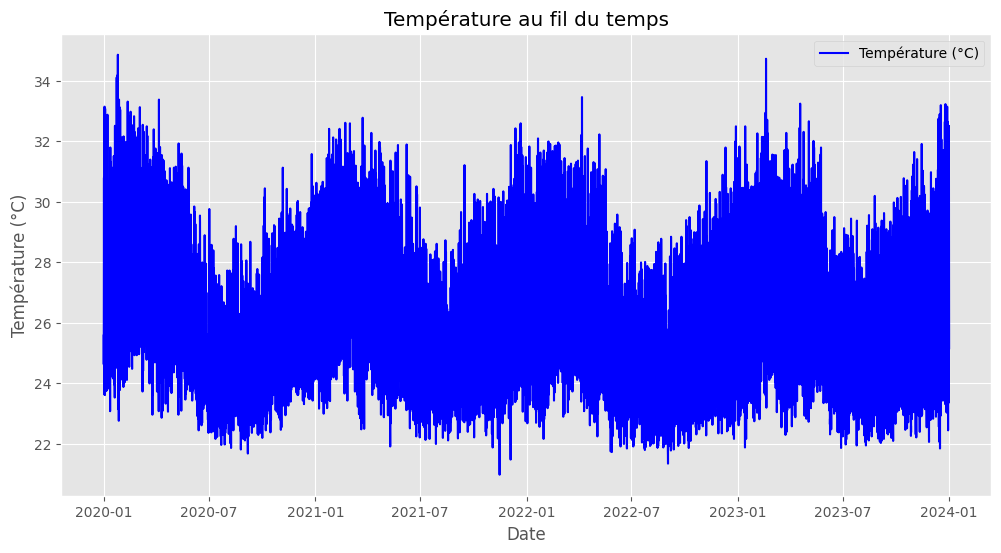

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Convertir l'index en type datetime si ce n'est pas déjà fait
new_hourly_dataframe.index = pd.to_datetime(new_hourly_dataframe.index)

# Visualisation de la série temporelle
plt.figure(figsize=(12, 6))
plt.plot(new_hourly_dataframe.index, new_hourly_dataframe['temperature_2m'], label='Température (°C)',color='blue')
plt.title('Température au fil du temps')
plt.xlabel('Date')
plt.ylabel('Température (°C)')
plt.legend()
plt.show()



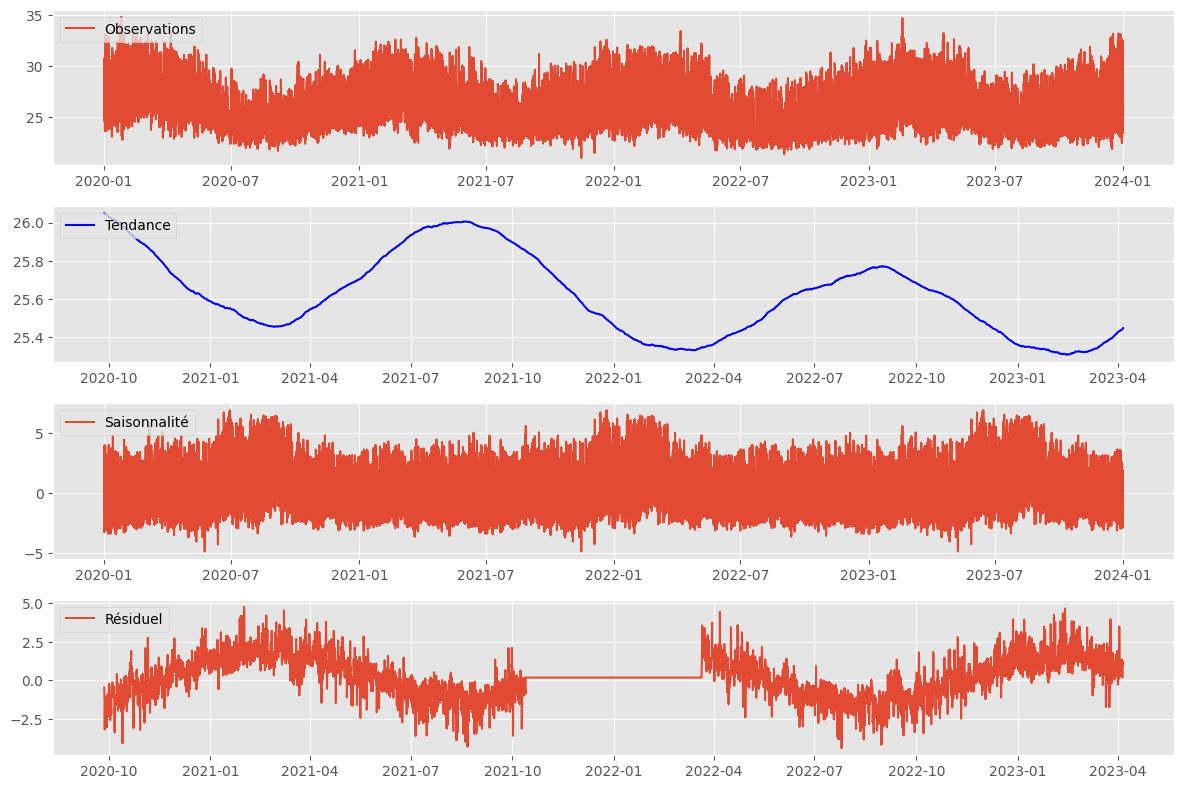

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Décomposition de la série temporelle avec une saisonnalité de 6 mois
decomposition = seasonal_decompose(new_hourly_dataframe['temperature_2m'], model='additive', period=24*30*6)

# Supposons une saisonnalité de 6 mois (période de 24 heures * 30 jours * 6 mois)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Tracez les composantes de la décomposition
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(new_hourly_dataframe.index, new_hourly_dataframe['temperature_2m'], label='Observations')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(new_hourly_dataframe.index, trend, label='Tendance', color='blue')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(new_hourly_dataframe.index, seasonal, label='Saisonnalité')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(new_hourly_dataframe.index, residual, label='Résiduel')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


D'après observation, les données neccessite des transformations avant les entrainements des modèles

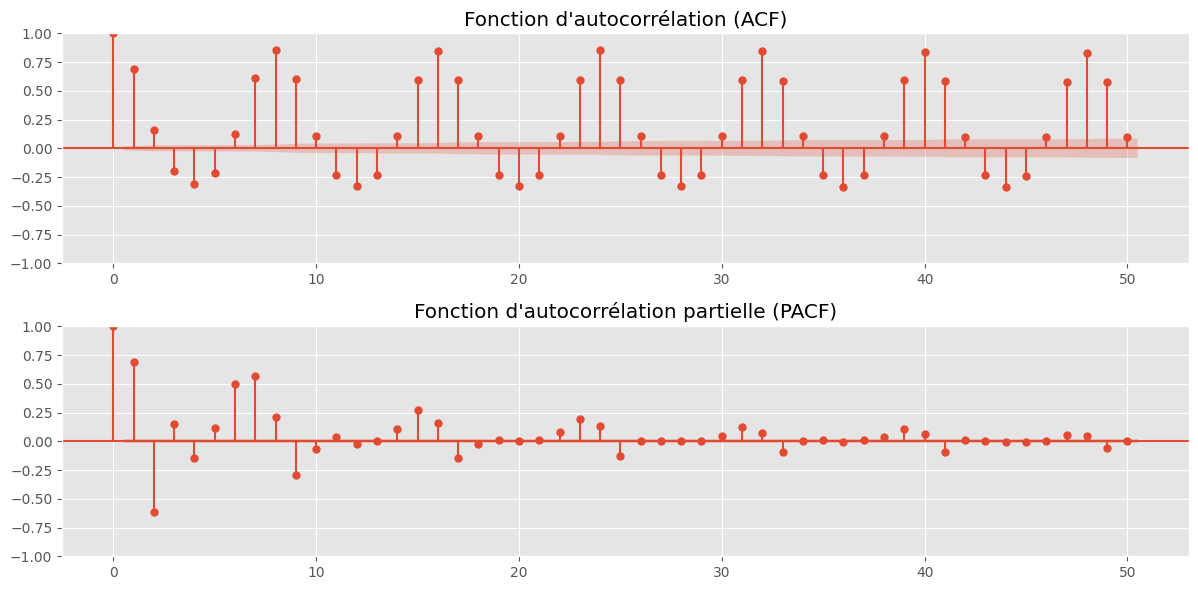

In [22]:
# Autocorrélation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))

plt.subplot(211)
plot_acf(new_hourly_dataframe['temperature_2m'], lags=50, ax=plt.gca())
plt.title('Fonction d\'autocorrélation (ACF)')

plt.subplot(212)
plot_pacf(new_hourly_dataframe['temperature_2m'], lags=50, ax=plt.gca())
plt.title('Fonction d\'autocorrélation partielle (PACF)')

plt.tight_layout()
plt.show()

#### 3) Vérification de la stationnarité

Vérifions la stationnarité de la série temporelle en utilisant les tests de Dickey-Fuller augmenté et KPSS.

In [23]:
from statsmodels.tsa import stattools
# Augmented Dickey-Fuller test
def check_adf_stat(ts):
    adf_results = stattools.adfuller(ts)
    adf_stat = adf_results[0]
    p_value = adf_results[1]
    critical_values = adf_results[4]
    print(f'The Augmented Dickey-Fuller test results\
          \n  test statistic {adf_stat:.3f},\
          \n  p-value: {p_value:.3f}\
          \n  critical values: {critical_values}')
    if (p_value > 0.05) or (adf_stat > critical_values['5%']):
        # there is a unit root
        print('The time series is NOT stationary')
    else:
        # there is no unit roots
        print('The time series is stationary')

In [24]:
# Kwiatkowski–Phillips–Schmidt–Shin test
def check_kpss_stat(ts):
    kpss_results = stattools.kpss(ts)
    kpss_stat = kpss_results[0]
    p_value = kpss_results[1]
    critical_values = kpss_results[3]
    print(f'The KPSS test results\
        \n  test statistic {kpss_stat:.3f},\
        \n  p-value: {p_value:.3f}\
        \n  critical values: {critical_values}')
    if (p_value < 0.05) or (kpss_stat > critical_values['5%']):
        print('The time series is NOT stationary')
    else:
        print('The time series is stationary')

In [25]:
warnings.filterwarnings('ignore')
print("---"*40)
check_adf_stat(new_hourly_dataframe)
print("---"*40)
check_kpss_stat(new_hourly_dataframe)
print("---"*40)

------------------------------------------------------------------------------------------------------------------------
The Augmented Dickey-Fuller test results          
  test statistic -4.654,          
  p-value: 0.000          
  critical values: {'1%': -3.4309115816789784, '5%': -2.8617881895614543, '10%': -2.566902106222889}
The time series is stationary
------------------------------------------------------------------------------------------------------------------------
The KPSS test results        
  test statistic 0.935,        
  p-value: 0.010        
  critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The time series is NOT stationary
------------------------------------------------------------------------------------------------------------------------


Le test de Dickey-Fuller dit que la serie temporelle est stationnaire, tant dis que le KPSS dit qu'il est non stationnaire

##### a) Box Cox transformation

Try the Box Cox transformation and print $\lambda$ found by [boxcox](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) function.

If $\lambda < 0$, assume $\lambda = 0$ and apply a simple logarithmic transformation.

In [26]:
from scipy.stats import boxcox
boxcox_results = boxcox(new_hourly_dataframe['temperature_2m'])
boxcox_lambda = boxcox_results[1]
print(f'optimal lambda: {boxcox_lambda:.2f}')

optimal lambda: -3.39


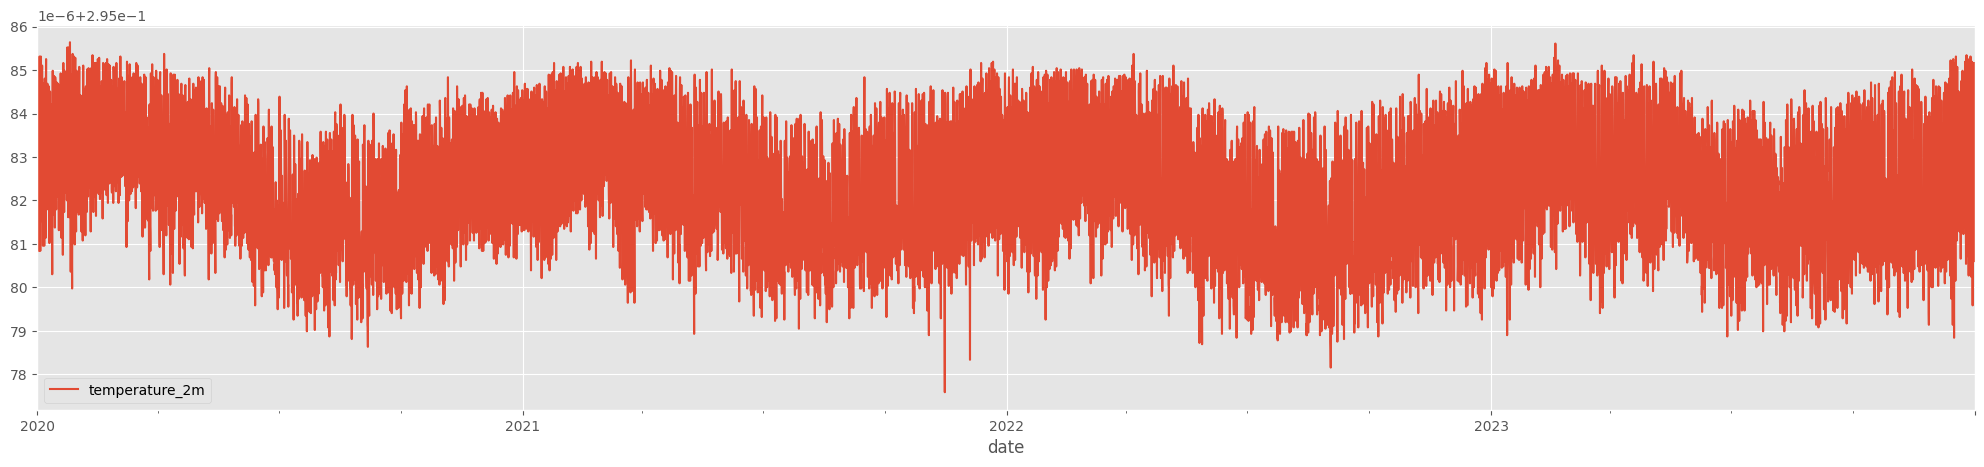

In [27]:
from copy import deepcopy

ts_boxcox = deepcopy(new_hourly_dataframe)
ts_boxcox['temperature_2m'] = boxcox_results[0]
ts_boxcox.plot();

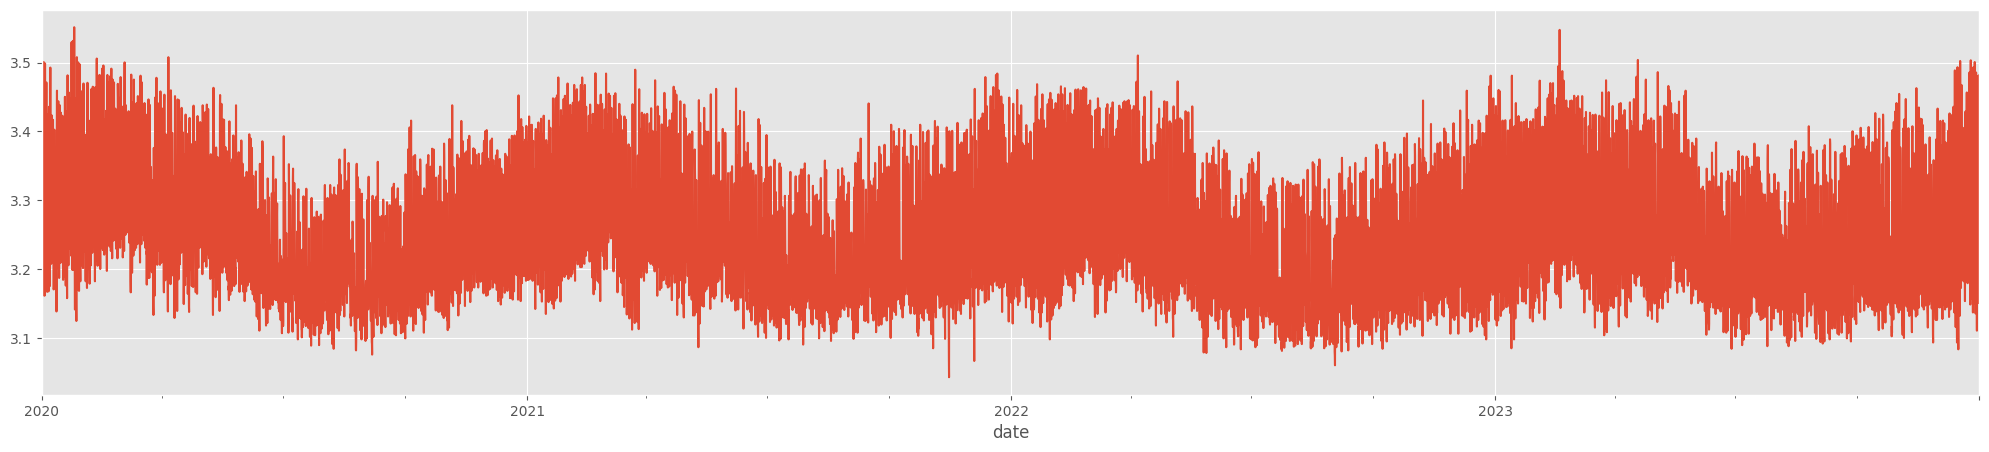

In [28]:
import numpy as np
new_hourly_dataframe = np.log(new_hourly_dataframe['temperature_2m'])
new_hourly_dataframe.plot();

##### b) Differencing

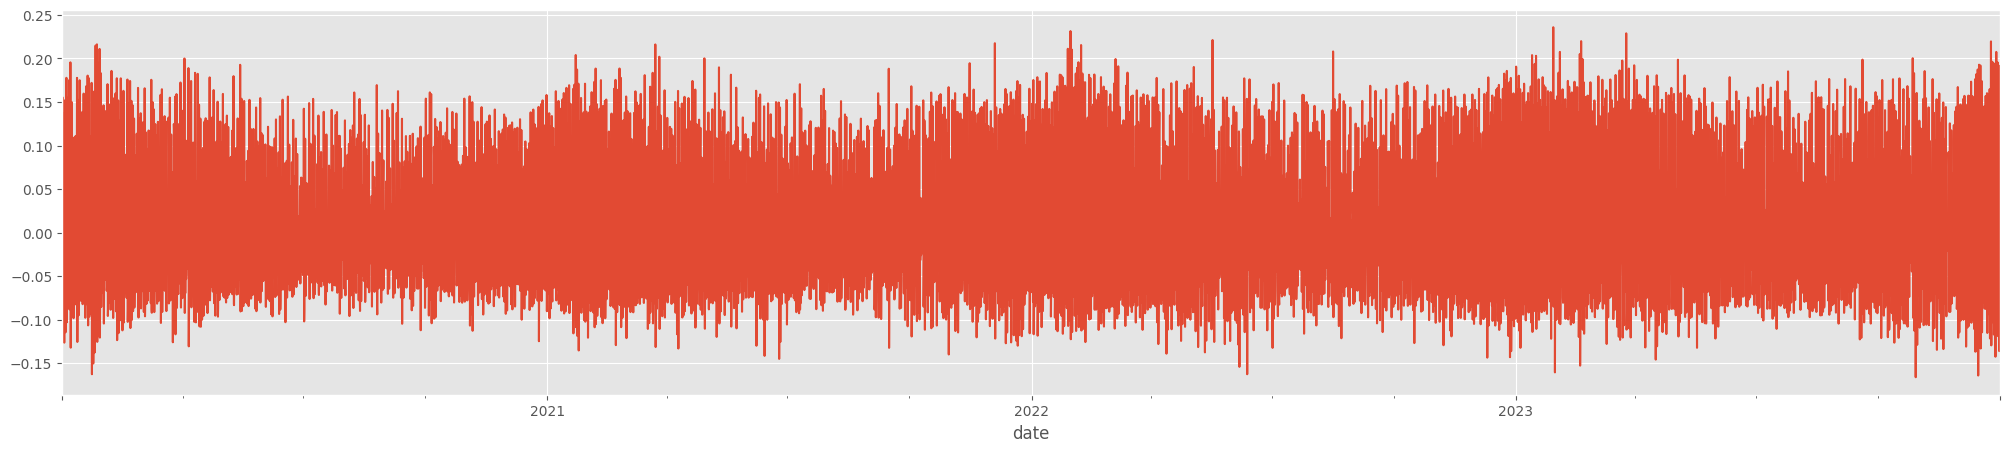

In [29]:
new_hourly_dataframe_diff = (new_hourly_dataframe - new_hourly_dataframe.shift(1))[1:]
new_hourly_dataframe_diff.plot();

In [30]:
warnings.filterwarnings('ignore')
print("---"*40)
check_adf_stat(new_hourly_dataframe_diff)
print("---"*40)
check_kpss_stat(new_hourly_dataframe_diff)
print("---"*40)

------------------------------------------------------------------------------------------------------------------------
The Augmented Dickey-Fuller test results          
  test statistic -27.028,          
  p-value: 0.000          
  critical values: {'1%': -3.4309115816789784, '5%': -2.8617881895614543, '10%': -2.566902106222889}
The time series is stationary
------------------------------------------------------------------------------------------------------------------------
The KPSS test results        
  test statistic 0.003,        
  p-value: 0.100        
  critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The time series is stationary
------------------------------------------------------------------------------------------------------------------------


Après transformation, les deux tests confirme la stationalité de notre serie temporelle

#### 1) Identifying ARIMA hyperparameters

Identifions les valeurs de $p$ et $q$ pour ARIMA (SARIMAX) en utilisant les tracés ACF (fonction d'autocorrélation) et PACF (fonction d'autocorrélation partielle).



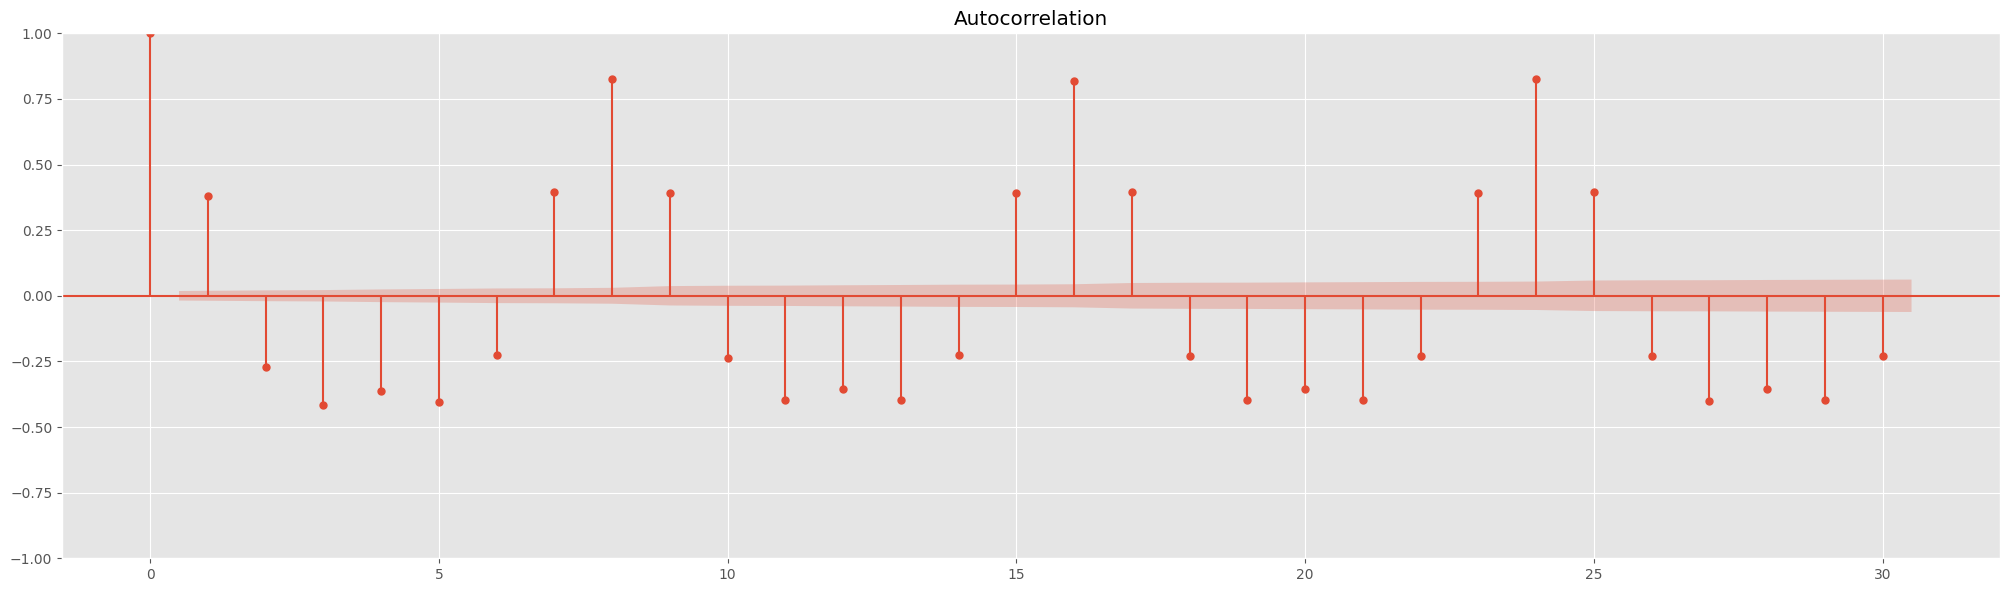

In [31]:
import statsmodels.graphics.tsaplots as tsaplots

fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(new_hourly_dataframe_diff, lags=30, ax=ax1);

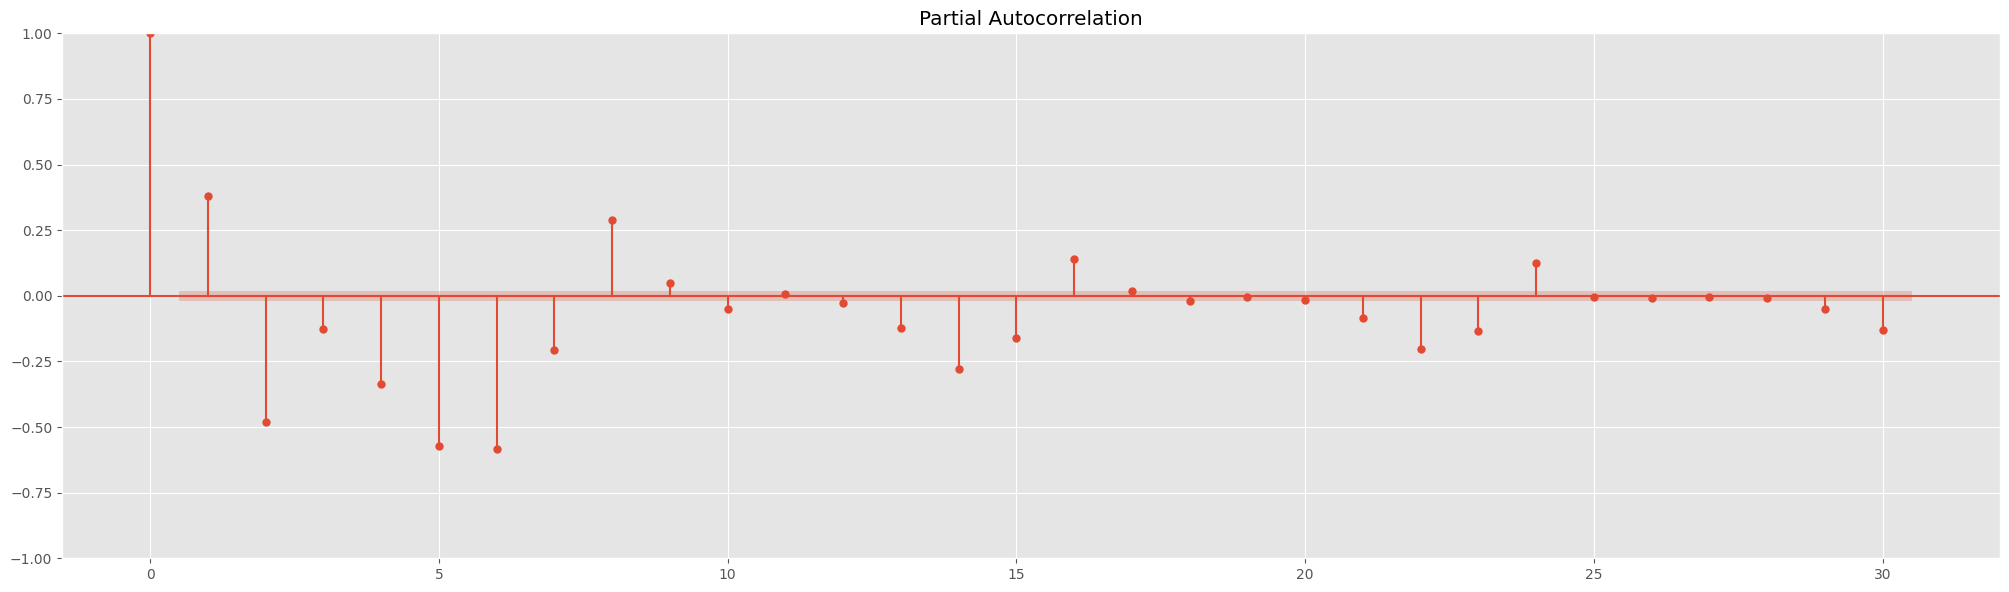

In [32]:
fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_pacf(new_hourly_dataframe_diff, lags=30, ax=ax1)

    Identification des valeurs de p et q :

    
   - p (ordre de l’autorégression) : Le nombre de retards (lags) significatifs dans l’ACF.

   - q (ordre de la moyenne mobile) : Le nombre de retards (lags) significatifs dans le PACF.

### III) Définition des ensembles d’entraînement, de validation et de test

Ici, nous utilisons le modèle SARIMAX. Par conséquent, nous utilisons les données initiales (non transformées à l'aide de la différenciation, de Box Cox, etc.).

Divisons les données en ensembles d'entraînement, de validation et de test.

* Entraînement : les premiers 65 % des données
* Validation : les 20 % suivants des données
* Test : les derniers 15 % des données

Vérifiez la forme de chaque ensemble et affichez-les sur un seul graphique.

In [33]:
len_train = int(len(new_hourly_dataframe) * 0.65)
len_val = int(len(new_hourly_dataframe) * 0.2)
ind_split_1 = len_train
ind_split_2 = len_train + len_val

ts_train = new_hourly_dataframe[:ind_split_1]
ts_val = new_hourly_dataframe[ind_split_1:ind_split_2]
ts_test = new_hourly_dataframe[ind_split_2:]

new_hourly_dataframe.shape, ts_train.shape, ts_val.shape, ts_test.shape

((11688,), (7597,), (2337,), (1754,))

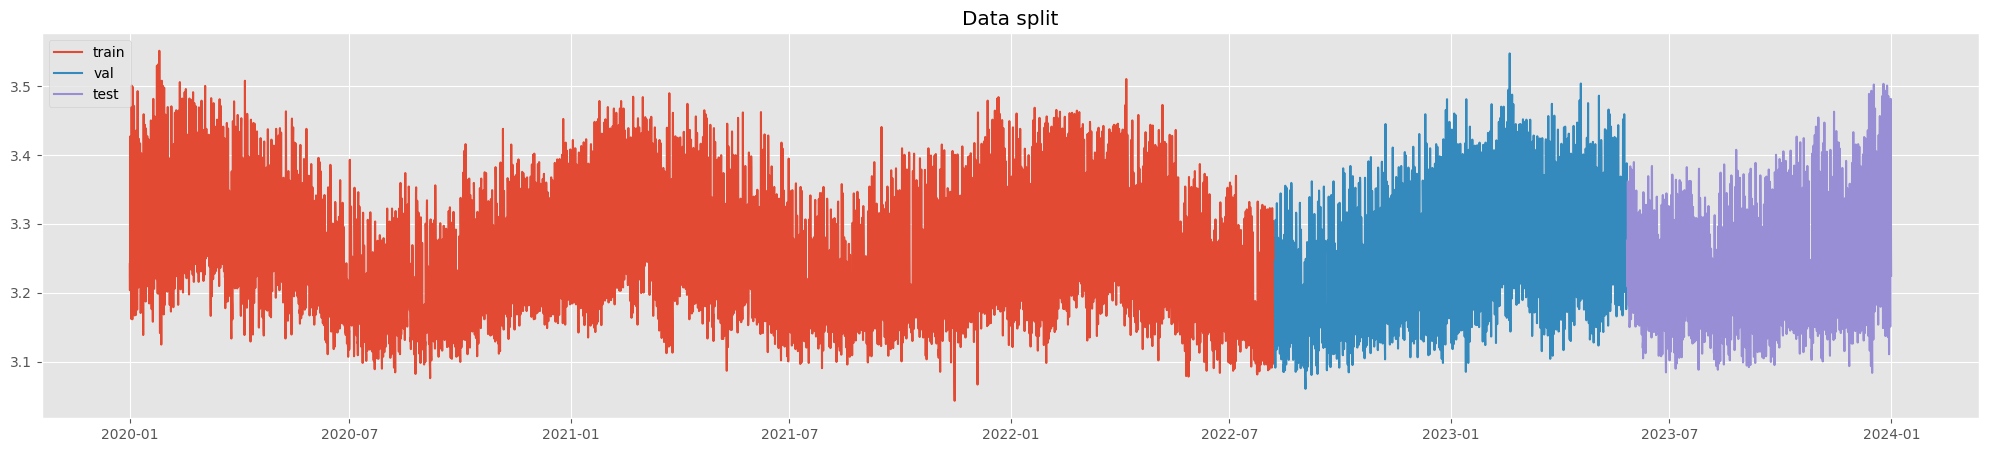

In [34]:
plt.figure()
plt.plot(ts_train.index, ts_train.values, label='train')
plt.plot(ts_val.index, ts_val.values, label='val')
plt.plot(ts_test.index, ts_test.values, label='test')
plt.legend(loc='best')
plt.title('Data split')
plt.show()

#### a) Tuning ARIMA hyperparameters of SARIMAX

Nous allons identifier les plages pour $p$ et $q$. précedemment, Nous avons constaté qu'une simple différenciation ($d=1$) a transformé la série temporelle en une série stationnaire. $d=0$ peut également être considéré.

Pour ajuster les hyperparamètres $(p,d,q)$, nous utilisons le modèle `SARIMAX` et la métrique `AIC` (Critère d'Information d'Akaike). En utilisant des boucles imbriquées, recherchons les valeurs de $(p,d,q)$ correspondant au `AIC` minimum.

Essayons d'utiliser l'erreur quadratique moyenne (RMSE) pour ajuster les hyperparamètres $(p,d,q)$.

In [35]:
p_values = range(0,6)
q_values = range(0,6)
d_values = range(0,2)

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')

best_score_aic, best_cfg_aic = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                model = SARIMAX(ts_train, order=order).fit()
                if model.aic < best_score_aic:
                    best_score_aic, best_cfg_aic = model.aic, order
                    print(f'SARIMAX{order} AIC={model.aic:.3f}')
            except:
                continue

print(f'Best SARIMAX{best_cfg_aic} AIC={best_score_aic:.3f}')

SARIMAX(0, 0, 0) AIC=39462.789
SARIMAX(0, 0, 1) AIC=29071.090
SARIMAX(0, 0, 2) AIC=19363.137
SARIMAX(0, 0, 3) AIC=11164.066
SARIMAX(0, 0, 4) AIC=4551.380
SARIMAX(0, 0, 5) AIC=-478.282
SARIMAX(0, 1, 0) AIC=-19762.180
SARIMAX(0, 1, 1) AIC=-22107.204
SARIMAX(0, 1, 2) AIC=-23072.721
SARIMAX(0, 1, 3) AIC=-25051.199
SARIMAX(0, 1, 4) AIC=-25202.744
SARIMAX(0, 1, 5) AIC=-25689.048
SARIMAX(1, 1, 5) AIC=-26077.123
SARIMAX(2, 1, 1) AIC=-26130.288
SARIMAX(2, 1, 2) AIC=-26448.128
SARIMAX(2, 1, 3) AIC=-26803.799
SARIMAX(2, 1, 4) AIC=-28941.660
SARIMAX(2, 1, 5) AIC=-29079.110
SARIMAX(3, 0, 5) AIC=-29659.616
SARIMAX(4, 0, 5) AIC=-29801.438
SARIMAX(4, 1, 3) AIC=-30507.656
SARIMAX(4, 1, 4) AIC=-31948.036
Best SARIMAX(4, 1, 4) AIC=-31948.036


Les paramètres dont on a un AIC bas est `Best SARIMAX(5, 0, 5) AIC=-32018.991`

> Ajouter une citation

> Ajouter une citation





In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

best_score_rmse, best_cfg_rmse = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                model = SARIMAX(ts_train, order=order).fit()
                ts_pred = model.predict(start=ts_val.index[0], end=ts_val.index[-1])
                rmse = mean_squared_error(ts_val.values, ts_pred.values, squared=False)

                if rmse < best_score_rmse:
                    best_score_rmse, best_cfg_rmse = rmse, order
                    print(f'SARIMAX{order} RMSE={rmse:.3f}')
            except:
                continue

print(f'Best SARIMAX{best_cfg_rmse} RMSE={best_score_rmse:.3f}')

SARIMAX(0, 0, 0) RMSE=3.243
SARIMAX(0, 0, 1) RMSE=3.243
SARIMAX(0, 0, 2) RMSE=3.242
SARIMAX(0, 0, 3) RMSE=3.242
SARIMAX(0, 0, 4) RMSE=3.242
SARIMAX(0, 0, 5) RMSE=3.241
SARIMAX(0, 1, 0) RMSE=0.091
Best SARIMAX(0, 1, 0) RMSE=0.091


Les paramètres dont on a un RMSE bas est `Best SARIMAX(0, 1, 0) RMSE=0.091`

##  Making predictions

Fit SARIMAX model on the union of **train** and **val** sets using the best values of $(p,d,q)$ found on the previous step. Produce forecasts on **test** set.

Plot train (train and val) and test data among with the forecasts for the test period.

Calculate the RMSE score on test data. Display it in the plot title.

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

ts_train_val = pd.concat([ts_train,ts_val], axis=0)
best_order = (5, 0, 5)
model_sarimax = SARIMAX(ts_train_val, order=best_order).fit()
ts_pred = model_sarimax.predict(start=ts_test.index[0], end=ts_test.index[-1])
rmse = mean_squared_error(ts_test.values, ts_pred.values, squared=False)
print(f'SARIMAX{best_order}\nAIC={model_sarimax.aic:.2f}\nRMSE (test)={rmse:.2f}')

SARIMAX(5, 0, 5)
AIC=-40569.33
RMSE (test)=0.09



- **SARIMAX(5, 0, 5)** : Cela indique que vous avez utilisé un modèle SARIMAX avec un ordre de différenciation de 0, et des ordres de 5 pour les composantes autorégressives (AR) et moyennes mobiles (MA). Cela signifie que le modèle utilise les 5 valeurs précédentes et les 5 erreurs de prédiction précédentes pour prédire la valeur actuelle.

- **AIC=-40566.04** : L'AIC, ou Critère d'Information d'Akaike, est une mesure de la qualité d'un modèle statistique. Il prend en compte à la fois la complexité du modèle et sa capacité à expliquer les données. Un AIC plus faible indique un meilleur modèle. Dans notre cas, l'AIC est négatif, ce qui est inhabituel car l'AIC est généralement positif. Cela pourrait être dû à une grande taille d'échantillon ou à des erreurs d'arrondi.

- **RMSE (test)=0.09** : Le RMSE, ou Root Mean Square Error, est une mesure est utilisée pour quantifier l'erreur d'un modèle de prédiction. Il représente l'écart moyen entre les valeurs prédites par le modèle et les valeurs réelles. Un RMSE plus faible indique un meilleur ajustement du modèle aux données. Dans notre cas, un RMSE de 0.09 sur l'ensemble de test indique que les prédictions du modèle sont relativement proches des valeurs réelles.


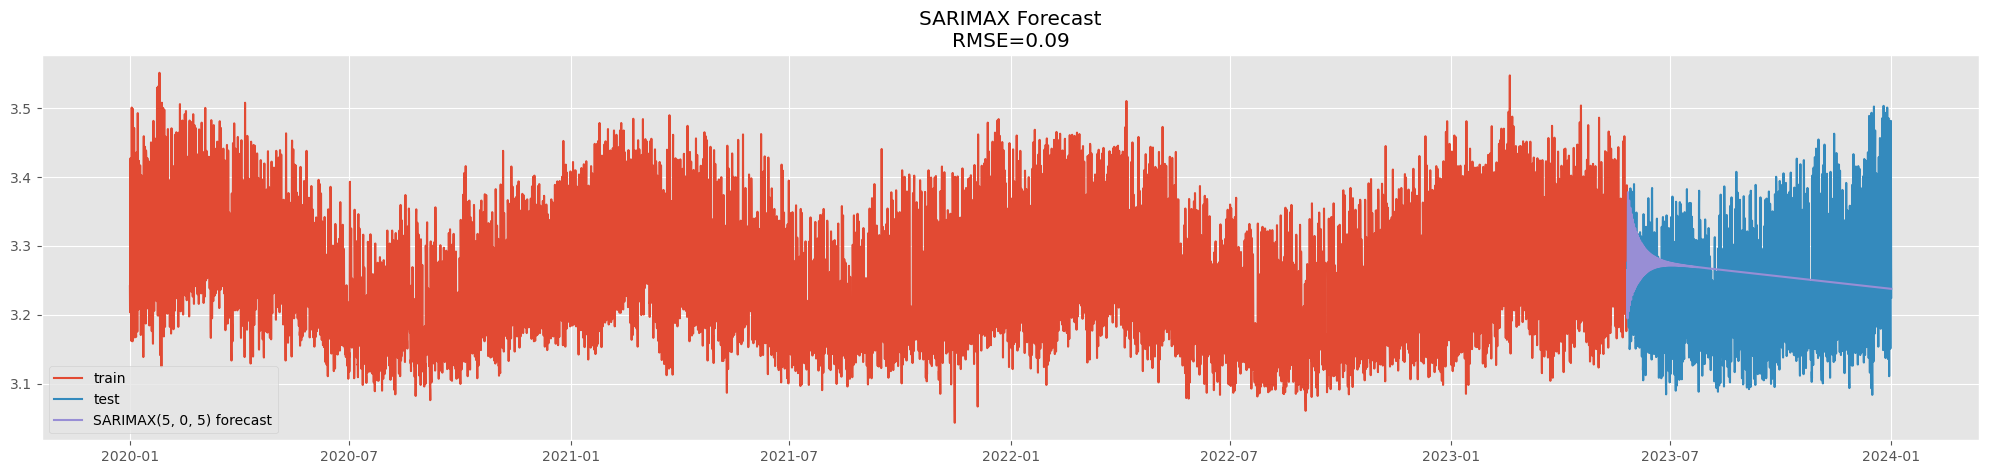

In [ ]:
plt.figure()
plt.plot(ts_train_val.index, ts_train_val.values, label='train')
plt.plot(ts_test.index, ts_test.values, label='test')
plt.plot(ts_pred.index, ts_pred.values, label=f'SARIMAX{best_order} forecast')
plt.legend(loc='best')
plt.title(f'SARIMAX Forecast\nRMSE={rmse:.2f}')
plt.show()

 #### Tuning seasonal parameters of SARIMAX

 Using ACF and PACF, detect the approximate ranges for $P$ and $Q$. Include $0$ to the ranges. Determine $s$.

Find the best combination $(P,D,Q)$:
*   Use SARIMAX model and AIC metric.
*   Use $(p,d,q)$ .
*   Try $D=0$ and $D=1$.



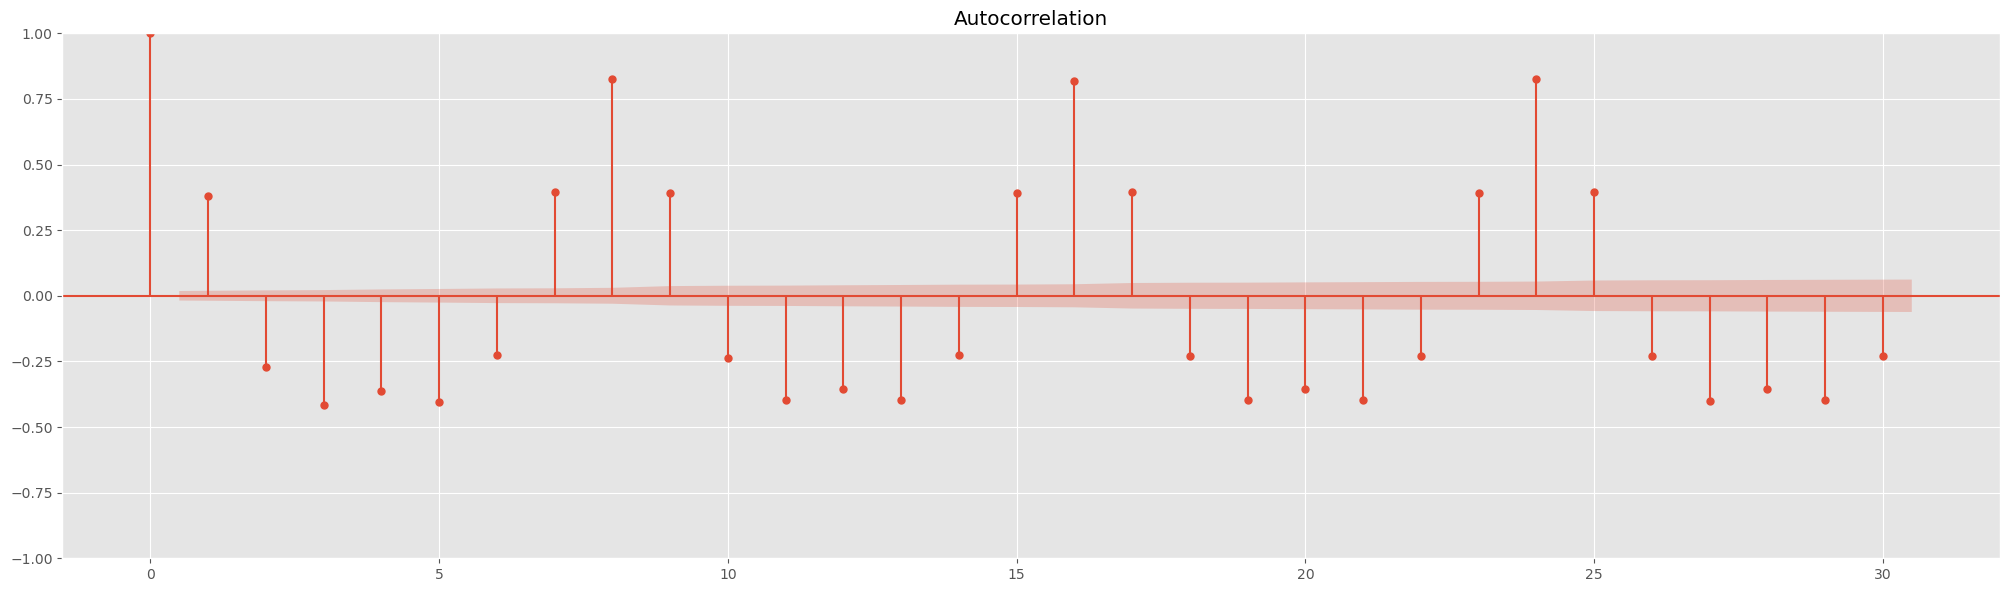

In [ ]:
import statsmodels.graphics.tsaplots as tsaplots

fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(new_hourly_dataframe_diff, lags=30, ax=ax1);

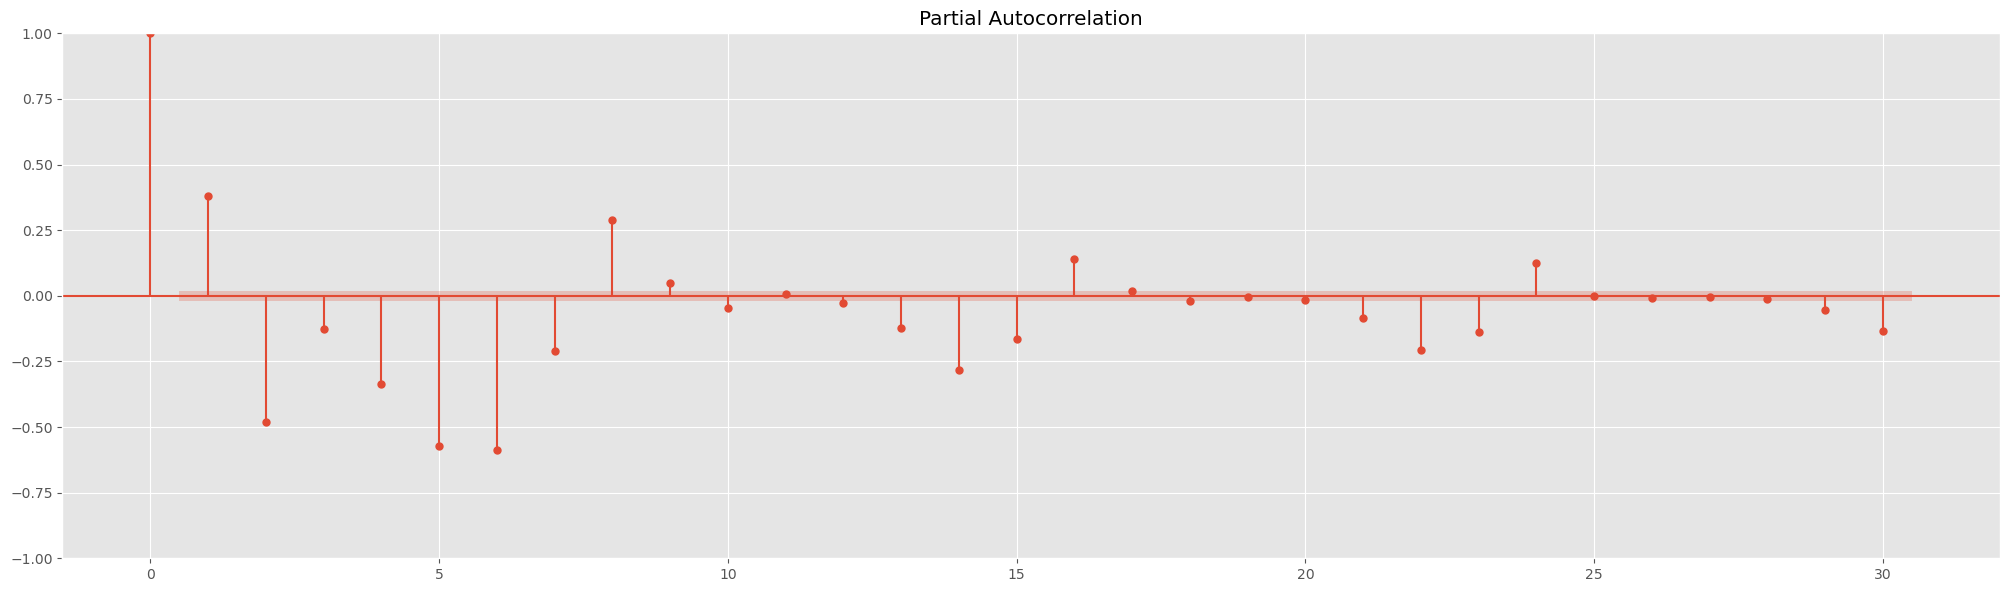

In [ ]:
fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_pacf(new_hourly_dataframe_diff, lags=30, ax=ax1)

In [ ]:
P_values = range(0,2)
Q_values = range(0,4)
D_values = range(0,2)
s = 24*30*6

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (5, 0, 5)
best_score_aic, best_cfg_aic = float("inf"), None

for P in P_values:
    for D in D_values:
        for Q in Q_values:
            seasonal_order=(P, D, Q, s)
            try:
                model = SARIMAX(ts_train, order=order, seasonal_order=seasonal_order).fit()
                if model.aic < best_score_aic:
                    best_score_aic, best_cfg_aic = model.aic, seasonal_order
                    print(f'SARIMAX{order}{seasonal_order} AIC={model.aic:.3f}')
            except:
                continue

print(f'Best SARIMAX{order}{best_cfg_aic} AIC={best_score_aic:.3f}')

SARIMAX(5, 0, 5)(0, 0, 0, 4320) AIC=-32018.991


In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

best_score_rmse, best_cfg_rmse = float("inf"), None

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                model = SARIMAX(ts_train, order=order).fit()
                ts_pred = model.predict(start=ts_val.index[0], end=ts_val.index[-1])
                rmse = mean_squared_error(ts_val.values, ts_pred.values, squared=False)

                if rmse < best_score_rmse:
                    best_score_rmse, best_cfg_rmse = rmse, order
                    print(f'SARIMAX{order} RMSE={rmse:.3f}')
            except:
                continue

print(f'Best SARIMAX{best_cfg_rmse} RMSE={best_score_rmse:.3f}')

SARIMAX(0, 0, 0) RMSE=3.243
SARIMAX(0, 0, 1) RMSE=3.243
SARIMAX(0, 0, 2) RMSE=3.242
SARIMAX(0, 0, 3) RMSE=3.242
SARIMAX(0, 0, 4) RMSE=3.242
SARIMAX(0, 0, 5) RMSE=3.241
SARIMAX(0, 1, 0) RMSE=0.091
Best SARIMAX(0, 1, 0) RMSE=0.091


##  Making predictions

Fit SARIMAX model on the union of **train** and **val** sets using the best values of $(p,d,q)$ found on the previous step. Produce forecasts on **test** set.

Plot train (train and val) and test data among with the forecasts for the test period.

Calculate the RMSE score on test data. Display it in the plot title.

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

ts_train_val = pd.concat([ts_train,ts_val], axis=0)
best_order = (5, 0, 5)
model_sarimax = SARIMAX(ts_train_val, order=best_order).fit()
ts_pred = model_sarimax.predict(start=ts_test.index[0], end=ts_test.index[-1])
rmse = mean_squared_error(ts_test.values, ts_pred.values, squared=False)
print(f'SARIMAX{best_order}\nAIC={model_sarimax.aic:.2f}\nRMSE (test)={rmse:.2f}')

SARIMAX(5, 0, 5)
AIC=-40569.33
RMSE (test)=0.09


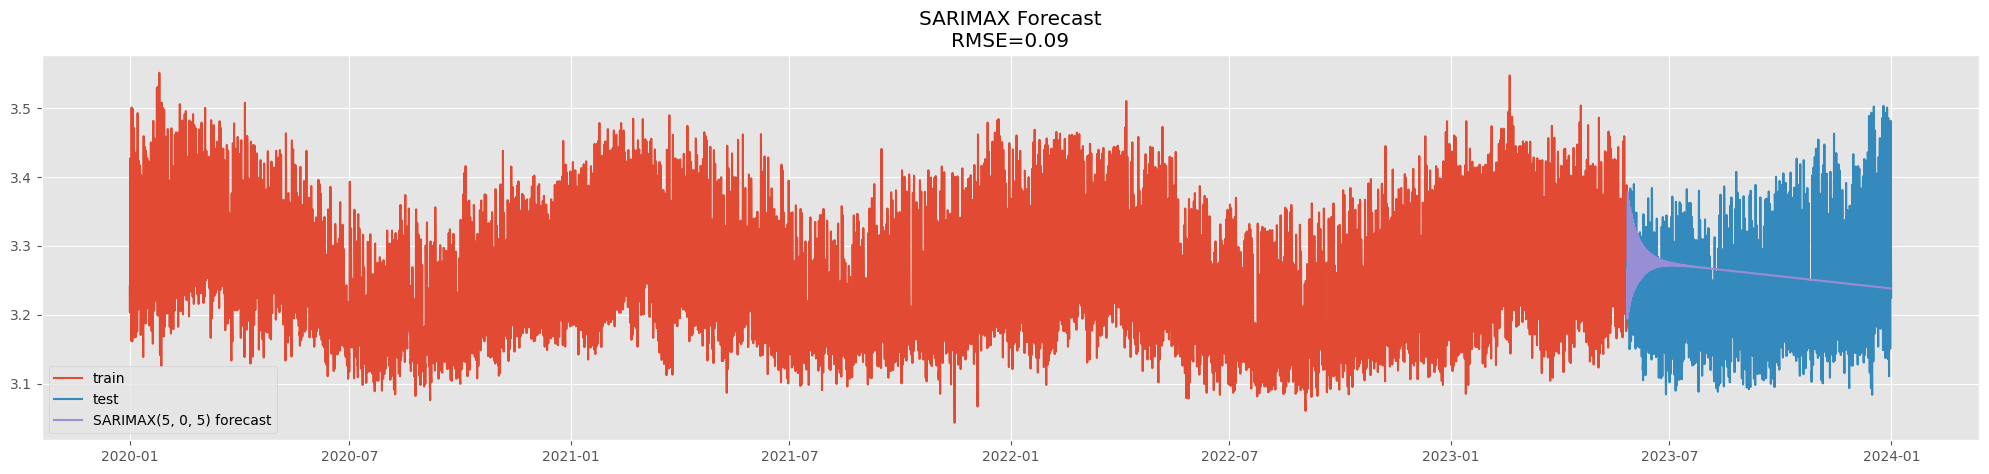

In [43]:
plt.figure()
plt.plot(ts_train_val.index, ts_train_val.values, label='train')
plt.plot(ts_test.index, ts_test.values, label='test')
plt.plot(ts_pred.index, ts_pred.values, label=f'SARIMAX{best_order} forecast')
plt.legend(loc='best')
plt.title(f'SARIMAX Forecast\nRMSE={rmse:.2f}')
plt.show()

# ARIMA & SARIMA

In [38]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [39]:
# Modèle ARIMA
arima_model = sm.tsa.ARIMA(ts_train, order=(5, 0, 2))
arima_result = arima_model.fit()
arima_pred = arima_result.predict(start=len(ts_train), end=len(ts_train) + len(ts_test) - 1, typ='levels')

# Modèle SARIMA
sarima_model = sm.tsa.SARIMAX(ts_train, order=(5, 0, 2), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()
sarima_pred = sarima_result.predict(start=len(ts_train), end=len(ts_train) + len(ts_test) - 1, typ='levels')

# Calcul de l'erreur quadratique moyenne pour chaque modèle
mse_arima = mean_squared_error(ts_test, arima_pred)
mse_sarima = mean_squared_error(ts_test, sarima_pred)


print("MSE ARIMA:", mse_arima)
print("MSE SARIMA:", mse_sarima)


MSE ARIMA: 0.007769013503079587
MSE SARIMA: 0.008701953707307161


######  Residual analysis

The **residuals** of a model are the difference between the predicted values and the actual values.

A good model has residuals that are similar to white noise, so the **residuals should be normally distributed and uncorrelated**.

###### Quantile-quantile (Q-Q) plot

**Qualitative analysis**: is the residuals distribution is close to the normal one?

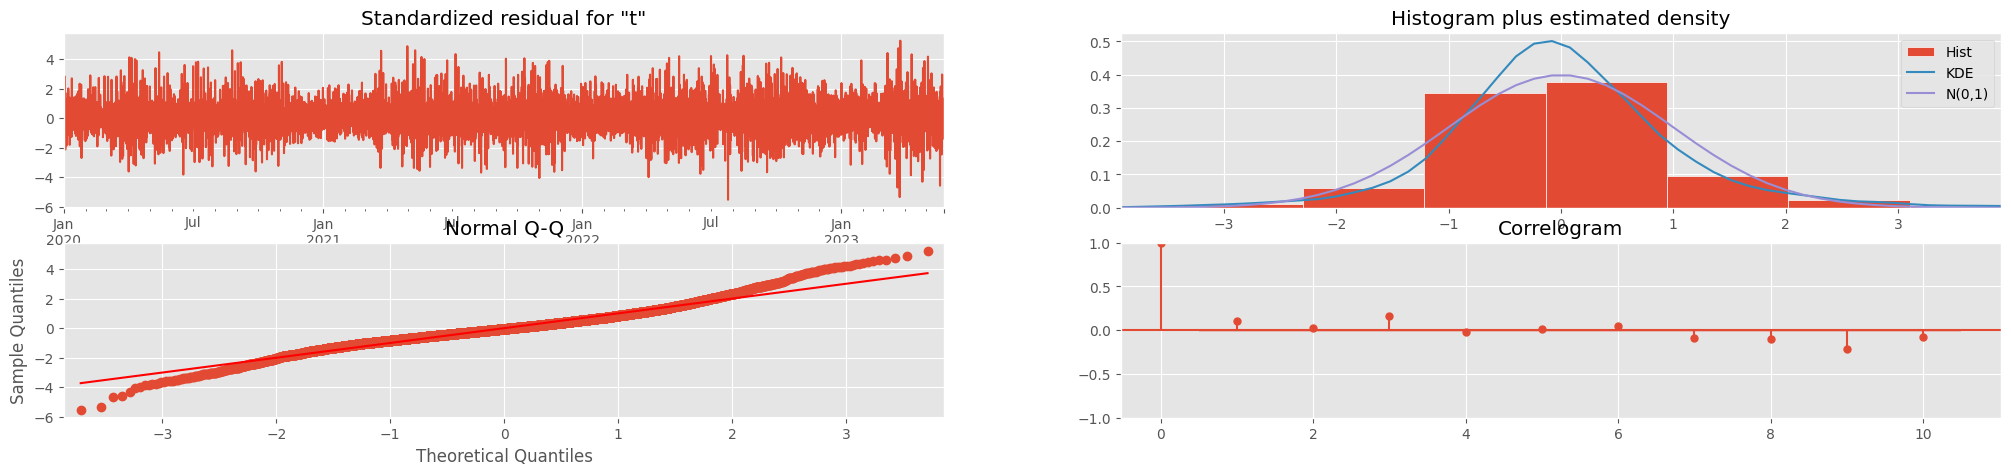

In [44]:
# from statsmodels.graphics.gofplots import qqplot

residuals = model_sarimax.resid
# qqplot(residuals, line='45');
model_sarimax.plot_diagnostics();


1. **Diagramme de résidus standardisés pour "t"** : Ce graphique montre une série temporelle de données fluctuant autour de la ligne zéro. Si les résidus sont bien répartis autour de zéro sans motif apparent, cela indique généralement que le modèle est approprié pour les données.

2. **Normal Q-Q plot** : Ce graphique compare les quantiles théoriques d'une distribution normale aux quantiles d'échantillons observés. Si les points suivent une ligne droite, cela indique que les données suivent une distribution normale.

3. **Histogramme avec une densité estimée et une courbe normale superposée** : Ce graphique présente la distribution des données et leur adéquation à une distribution normale. Si la courbe de densité suit de près la courbe normale, cela indique que les données sont normalement distribuées.

4. **Correlogramme** : Ce graphique affiche les corrélations entre différentes variables sous forme de points rouges sur une ligne horizontale. Les points qui sont loin de la ligne zéro indiquent une forte corrélation.



## Machine learning

### Lag features

Add the first 7 lag features (lag of 1, 2, ..., 7 jours).

Drop rows containing NaNs.

In [45]:
for i in range(1, 8):
    hourly_dataframe[f"lag_{i}"] = hourly_dataframe['temperature_2m'].shift(i)
hourly_dataframe.head()

,temperature_2m,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
2020-01-01 00:00:00+00:00,25.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00+00:00,26.42,25.62,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00+00:00,24.67,26.42,25.62,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00+00:00,24.62,24.67,26.42,25.62,NaN,NaN,NaN,NaN
2020-01-01 04:00:00+00:00,24.77,24.62,24.67,26.42,25.62,NaN,NaN,NaN


In [46]:
hourly_dataframe.dropna(inplace=True)
hourly_dataframe.head()

,temperature_2m,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
2020-01-01 07:00:00+00:00,26.17,24.72,24.47,24.77,24.62,24.67,26.42,25.62
2020-01-01 08:00:00+00:00,27.82,26.17,24.72,24.47,24.77,24.62,24.67,26.42
2020-01-01 09:00:00+00:00,29.32,27.82,26.17,24.72,24.47,24.77,24.62,24.67
2020-01-01 10:00:00+00:00,30.72,29.32,27.82,26.17,24.72,24.47,24.77,24.62
2020-01-01 11:00:00+00:00,31.92,30.72,29.32,27.82,26.17,24.72,24.47,24.77


###  Split data

Split data into train and test sets.

*   train - the first 85% of data
*   test - the last 15% of data



In [47]:
from sklearn.model_selection import train_test_split

X = hourly_dataframe.drop('temperature_2m', axis=1)
y = hourly_dataframe['temperature_2m']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
X_train.shape, X_test.shape

((29798, 7), (5259, 7))

### Fit Linear Regression using aggregated features

Train a Linear Regression model on train data and calculate  R2  on test data. Plot the actual and the predicted values.

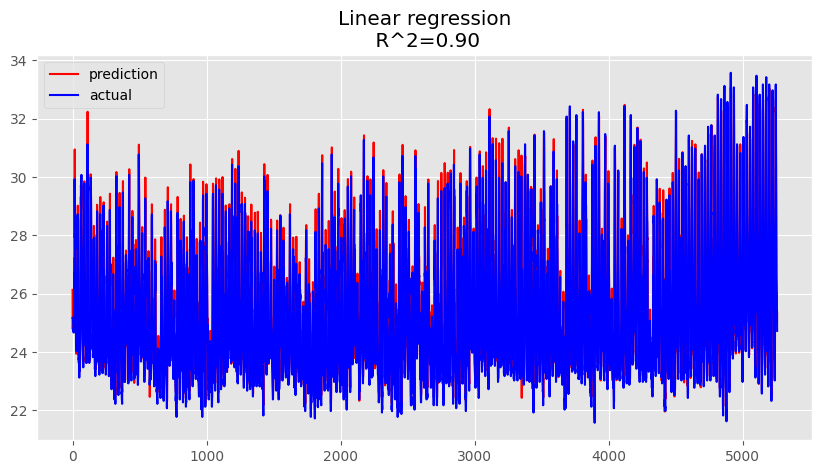

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test.values, color="blue",label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n R^2={r2_score(y_test, y_pred):.2f}");

 Le coefficient de détermination (R^2) est de 0,90, ce qui indique une forte corrélation entre les valeurs réelles et prédites.

Un R^2 de 0,90 signifie que 90% de la variabilité des données réelles peut être expliquée par le modèle de régression linéaire. C’est généralement considéré comme un bon ajustement du modèle. Cependant, il est important de noter que R^2 seul ne peut pas déterminer si le modèle est approprié. D’autres diagnostics de régression, tels que l’analyse des résidus, sont également nécessaires pour une évaluation complète du modèle

### Aggregated features and preprocessing function

Define a preprocessing function wrapping the following steps:

1.   Split data into train and test sets with the default test_size of 15%
2.   Add lag features for a given lags range (first 7 by default)
3.   Add predefined aggregated features (monthly average)

In [49]:
# Function that returns a dictionary where:
# the keys correspond to unique values of `cat_feature`, and
# the values correspond to average values of `real_feature`.
def get_mean_by_cat(data, cat_feature, value_feature):
    return dict(data.groupby(cat_feature)[value_feature].mean())

In [50]:
from sklearn.model_selection import train_test_split

def preprocess_data(data, lag_start=1, lag_end=8, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # add time series lags as features
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data['temperature_2m'].shift(i)

    # drop NaNs generated by adding lag features
    data = data.dropna()

    data["Jours"] = data.index.month

    X = data.drop("temperature_2m", axis=1)
    y = data["temperature_2m"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

    # calculate average values only on train data to avoid data leak
    monthly_average = get_mean_by_cat(data.loc[X_train.index], "Jours", "temperature_2m")
    X_train["Jours_average"] = list(map(monthly_average.get, X_train["Jours"]))
    X_test["Jours_average"] = list(map(monthly_average.get, X_test["Jours"]))

    # drop features that have been used for calculating average values of the target variable
    X_train.drop(["Jours"], axis=1, inplace=True)
    X_test.drop(["Jours"], axis=1, inplace=True)

    return X_train, X_test, y_train, y_test

In [51]:
X_train, X_test, y_train, y_test = preprocess_data(hourly_dataframe)
X_train.shape, X_test.shape

((29792, 8), (5258, 8))

###  Try different lag features

Get train and test sets using `preprocess_data` for lags from 1 to 11.

Train a Linear Regression model on train data and calculate  R2  on test data. Plot the actual and the predicted values.

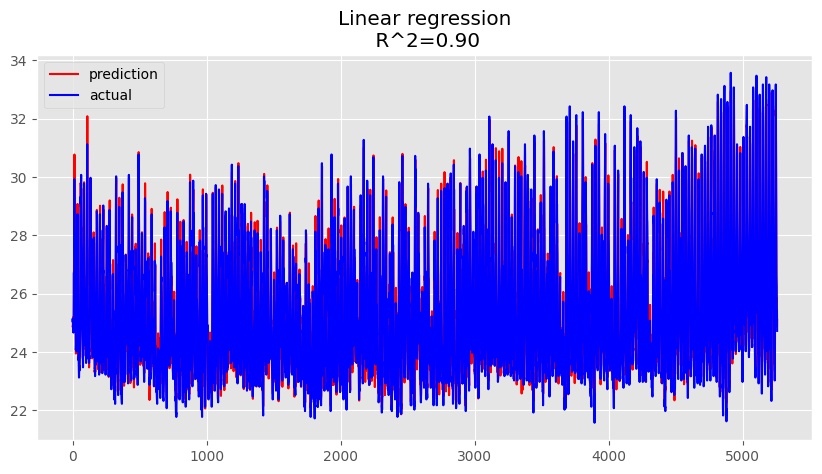

In [52]:
X_train, X_test, y_train, y_test = preprocess_data(hourly_dataframe, lag_end=12)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test.values, color="blue",label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n R^2={r2_score(y_test, y_pred):.2f}");

### Try another regression algorithm (RandomForestRegressor)

Check if using RandomForestRegressor improves the model quality.

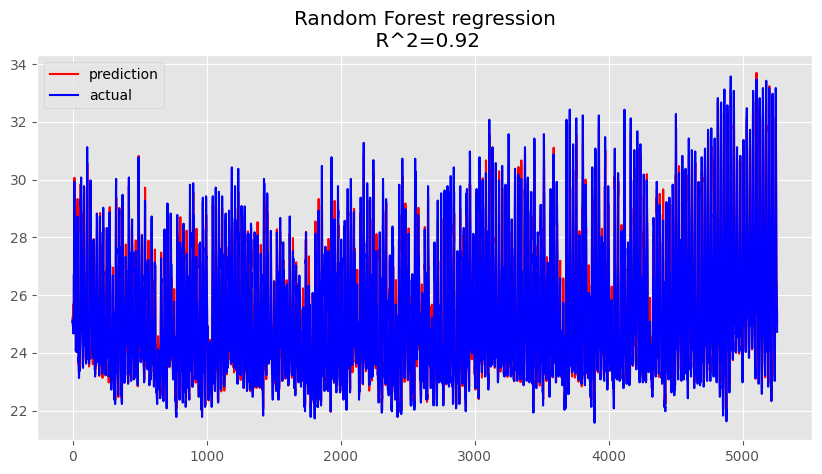

In [53]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = preprocess_data(hourly_dataframe, lag_end=12)

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_pred, "r", label="prediction")
plt.plot(y_test.values, label="actual", color="blue")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Random Forest regression\n R^2={r2_score(y_test, y_pred):.2f}");

 Le coefficient de détermination (R^2) est de 0,92, ce qui indique une forte corrélation entre les valeurs réelles et prédites.

Un R^2 de 0,92 signifie que 92% de la variabilité des données réelles peut être expliquée par le modèle de régression linéaire.

### IV) Test de prédiction

In [54]:
prediction_sarimax = model_sarimax.predict(start="2022-05-26", end="2022-05-27")
print("Prédiction SARIMAX:", prediction_sarimax)


TypeError: Cannot compare tz-naive and tz-aware timestamps